In [1]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *

import src.Modules.Loaders.DataFormatter as DF
from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion, DE_sim
from src.custom_functions import MSE, unique_inputs, to_torch, to_numpy, load_model, recover_binn_params

#For plotting
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']
colors_plot = colors[:11]
markers_plot = markers[:5]
fontsize=24

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

/opt/tcnjhpc/Python-3.9.12/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Device set to cpu
Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
'''
Forecasting the Pulling ABM and the Adhesion ABM

if scenario = "Pulling_vary_Ppull", then we simulate the Pulling ABM 
                                    while varying Ppull and fixing rmp

if scenario = "Pulling_vary_rmp", then we simulate the Pulling ABM 
                                    while varying rmp and fixing Ppull

if scenario = "Adhesion_vary_Ppull", then we simulate the Adhesion ABM 
                                    while varying Padh and fixing rmh

if scenario = "Adhesion_vary_rmp", then we simulate the Adhesion ABM 
                                    while varying rmh and fixing Padh
'''
path = '../../data/'

#scenario = "Pulling_vary_Ppull"
scenario = "Pulling_vary_rmp"
#scenario = "Adhesion_vary_Padh"
#scenario = "Adhesion_vary_rmh"

if scenario == "Pulling_vary_Ppull":
    Pints = np.round(np.linspace(0.0,1.0,11),2)[:,None]
    rms = np.round(1.0*np.ones((11,)),2)[:,None]
    params = np.hstack([rms,Pints])
    diffusion = simple_pulling_diffusion
    filename_header = "simple_pulling_mean_25"
    suptitle = "$p_{pull}$"
    DMF = "$\mathcal{D}^{pull}(T)$"
    
elif scenario == "Pulling_vary_rmp":
    Pints = np.round(.5*np.ones((10,)),2)[:,None]
    rms = np.round(np.linspace(0.1,1.0,10),2)[:,None]
    params = np.hstack([rms,Pints])
    diffusion = simple_pulling_diffusion
    filename_header = "simple_pulling_mean_25"
    suptitle = "$r_m^{pull}$"
    DMF = "$\mathcal{D}^{pull}(T)$"
    
elif scenario == "Adhesion_vary_Padh":
    Pints = np.round(np.linspace(0.0,1.0,11),2)[:,None]
    rms = np.round(1.0*np.ones((11,)),2)[:,None]
    params = np.hstack([rms,Pints])
    diffusion = simple_adhesion_diffusion    
    filename_header = "simple_adhesion_mean_25"
    suptitle = "$p_{adh}$"
    DMF = "$\mathcal{D}^{adh}(T)$"
    
elif scenario == "Adhesion_vary_rmh":
    Pints = np.round(.5*np.ones((10,)),2)[:,None]
    rms = np.round(np.linspace(0.1,1.0,10),2)[:,None]
    params = np.hstack([rms,Pints])
    diffusion = simple_adhesion_diffusion        
    filename_header = "simple_adhesion_mean_25"
    suptitle = "$r_m^{adh}$" 
    DMF = "$\mathcal{D}^{adh}(T)$"

### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

### Initialize lists storing the model wrappers, BINNs, 
### data inputs (x,t), and outputs (T(x,t))
models = []
binns = []
inputs_list = []
outputs_list = []

for rm, Pinteraction in params:
    
    if "Pulling" in scenario:
        file_name = f'{filename_header}_Pm_{rm}_Ppull_{Pinteraction}'
    elif "Adhesion" in scenario:
        file_name = f'{filename_header}_Pm_{rm}_Padh_{ Pinteraction}'    

    ### load in data
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
    x = inputs[:,0]
    t = inputs[:,1]
    binn_name  = f"{model_name}"
    save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
    model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=x,t=t)

    models.append(model)
    binns.append(binn)
    inputs_list.append(inputs)
    outputs_list.append(outputs)

## Plot Diffusion rates

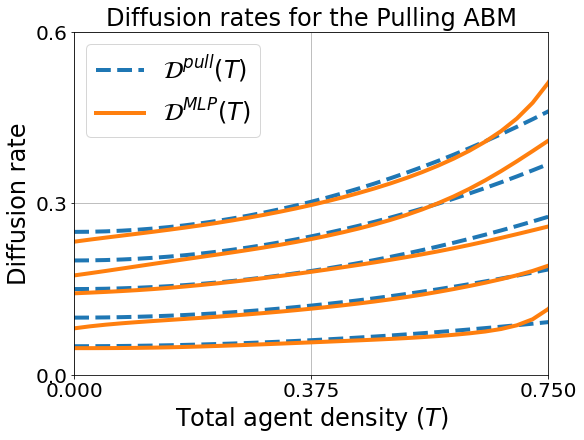

In [7]:
#initialize plot
fig = plt.figure(figsize=(8,6),layout="constrained")
ylabels = ['Diffusion rate']
xlabels = ['Total agent density ($T$)']
if "Pulling" in scenario:
    titles = [r'Diffusion rates for the Pulling ABM']
else:
    titles = [r'Diffusion rates for the Adhesion ABM']

ax1 = fig.add_subplot(1,1,1)
ax1.grid()
axs = [ax1]

# create T mesh
T_mesh = np.linspace(0, 1, 41)

### plot
count = 0
for binn, Pint, rm, color, marker in zip(binns[1::2],Pints[1::2],rms[1::2],colors_plot, markers_plot):

    # Compute D^MLP(T)
    D_mesh = to_numpy(binn.diffusion(to_torch(T_mesh)[:, None]))
    
    label = DMF if count == 0 else ""    
    ax1.plot(T_mesh, diffusion(T_mesh,[rm/4,Pint]),"--", color = colors[0],linewidth=4,label=label)
    label = "$\mathcal{D}^{MLP}(T)$" if count == 0 else ""    
    ax1.plot(T_mesh, D_mesh, '-', color=colors[1],linewidth=4,markersize=10, label = label)
        
    count += 1
    
for xlabel, ylabel, title in zip(xlabels, ylabels, titles):
    ax1.set_xlabel(xlabel,fontsize=fontsize)
    ax1.set_ylabel(ylabel,fontsize=fontsize)
    ax1.set_title(title,fontsize=fontsize)

if scenario == 'Pulling_vary_Ppull': 
    yticks = [.25, .45,.65]
    axs[0].set_ylim([.2,0.65])
if scenario == 'Pulling_vary_rmp':
    yticks = [0, .3,.6]
    axs[0].set_ylim([0.0,0.6])
if scenario == 'Adhesion_vary_Padh':
    yticks = [0, 0.15, .3]
    axs[0].set_ylim([0.0,0.3])
if scenario == 'Adhesion_vary_rmh':
    yticks = [0, 0.15, .3]
    axs[0].set_ylim([0.0,0.3])
axs[0].set_xlim([0,0.75])
plt.xticks([0, .75/2, 0.75],fontsize=20)    
plt.yticks(yticks,fontsize=20) 

plt.legend(fontsize=24)
plt.savefig(f'../../results/figures/learned_params_{scenario}.pdf', format='pdf')

## Plot Mean-squared Error (MSE) values

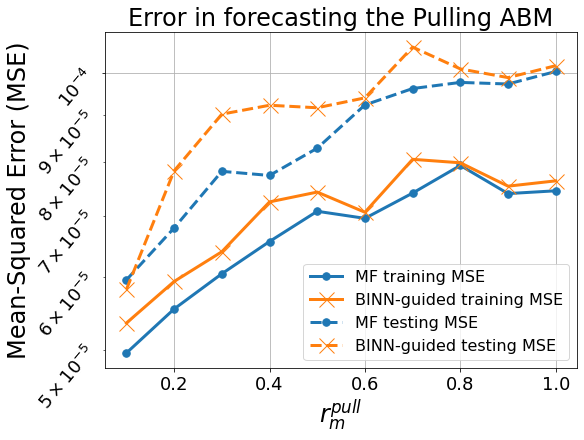

In [8]:
### Initialize lists storing the training and testing MSE values

MSEs_MF_train = []
MSEs_binn_train = []
MSEs_MF_test = []
MSEs_binn_test = []

for binn, inputs, outputs, param_combo in zip(binns,inputs_list,outputs_list,params):
    
    rm, Pinteraction = param_combo
    
    ### Simulate mean-field PDE
    x,t = unique_inputs(inputs)
    U = outputs.reshape((len(x),-1))
    q = [rm/4,Pinteraction]
    IC = U[:,0]
    
    t_max = np.max(t)
    t_perc = 0.75
    U_train = U[:,t<=t_perc*t_max]
    U_test  = U[:,t >t_perc*t_max]
        
    if ("Adhesion" in scenario) and (Pinteraction > 0.75):
        
        #Mean-field DE ill-posed for Adhesion ABM when Padh > 0.75
        MSE_MF_train = np.nan
        MSE_MF_test = np.nan
        
    else:
        #simulate mean-field PDE
        sol = DE_sim(x, 
                    t, 
                    q, 
                    IC, 
                    Diffusion_function = diffusion)
        
        sol_train = sol[:,t<=t_perc*t_max]
        sol_test  = sol[:,t >t_perc*t_max]
        #MSE Values
        MSE_MF_train = MSE(sol_train, U_train)
        MSE_MF_test = MSE(sol_test, U_test)

    ### load in previously-computed BINN-guided PDE        
    if "Pulling" in scenario:
        file_name = f'{filename_header}_Pm_{rm}_Ppull_{Pinteraction}_pde_weight_{pde_weight}'
    elif "Adhesion" in scenario:
        file_name = f'{filename_header}_Pm_{rm}_Padh_{ Pinteraction}_pde_weight_{pde_weight}'
    pde_mat = np.load(f"../../results/PDE_sims/PDE_sim_{binn_name}_{file_name}.npy",allow_pickle=True).item()
    #BINN-guided PDE
    sol_binn = pde_mat['U_sim']
    sol_binn_train = sol_binn[:,t<=t_perc*t_max]
    sol_binn_test  = sol_binn[:,t >t_perc*t_max]
    #MSE values
    MSE_binn_train = MSE(sol_binn_train, U_train)
    MSE_binn_test = MSE(sol_binn_test, U_test)
                        
    MSEs_MF_train.append(MSE_MF_train)
    MSEs_MF_test.append(MSE_MF_test)
    MSEs_binn_train.append(MSE_binn_train)
    MSEs_binn_test.append(MSE_binn_test)

#convert to ndarray
MSEs_MF_train = np.array(MSEs_MF_train)
MSEs_MF_test = np.array(MSEs_MF_test)
MSEs_binn_train = np.array(MSEs_binn_train)
MSEs_binn_test = np.array(MSEs_binn_test) 

if scenario == "Pulling_vary_rmp":
    param_vary_name = "$r_m^{pull}$"
    Pvarys = rms
elif scenario == "Pulling_vary_Ppull":
    param_vary_name = "$p_{pull}$"
    Pvarys = Pints
elif scenario == "Adhesion_vary_Padh":
    param_vary_name = "$p_{adh}$"
    Pvarys = Pints
elif scenario == "Adhesion_vary_rmh":
    param_vary_name = "$r_m^{adh}$"
    Pvarys = rms
    
if "Pulling" in scenario:
    filename_DE_plot = f"BINN_MF_compare_Pm_{rm}_Ppull_{Pinteraction}"
elif "Adhesion" in scenario:
    filename_DE_plot = f"BINN_MF_compare_Pm_{rm}_Padh_{Pinteraction}"    
    
fig = plt.figure(figsize=(8,6), layout="constrained")
ax = fig.add_subplot(111)
ax.grid()
yscale = 1e0
ax.semilogy(Pvarys, yscale*MSEs_MF_train, ".-",label = "MF training MSE",markersize=15, linewidth=3, c = colors[0])
ax.semilogy(Pvarys, yscale*MSEs_binn_train, "x-",label = "BINN-guided training MSE",markersize=15, linewidth=3, c = colors[1])
ax.semilogy(Pvarys, yscale*MSEs_MF_test, ".--",label = "MF testing MSE",markersize=15, linewidth=3, c = colors[0])
ax.semilogy(Pvarys, yscale*MSEs_binn_test, "x--",label = "BINN-guided testing MSE",markersize=15, linewidth=3, c = colors[1])

ax.set_xlabel(param_vary_name,fontsize=fontsize)
ax.set_ylabel("Mean-Squared Error (MSE)",fontsize=fontsize)

if "Pulling" in scenario:
    ax.set_title("Error in forecasting the Pulling ABM",fontsize=fontsize)
else:
    ax.set_title("Error in forecasting the Adhesion ABM",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=.75*fontsize)
ax.tick_params(axis='both', which='minor', labelsize=.75*fontsize)
ax.tick_params(axis='y', which='major', rotation = 50)
ax.tick_params(axis='y', which='minor', rotation = 50)

plt.legend(fontsize=16)
plt.savefig(f"../../results/figures/training_testing_MSE_{filename_DE_plot}.pdf")   